In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

file_path = "/content/drive/MyDrive/Untitled_spreadsheet.xlsx"
xls = pd.ExcelFile(file_path)

dfs = []
for sheet in xls.sheet_names:
    dfs.append(pd.read_excel(file_path, sheet_name=sheet))

# Combine row-wise
df = pd.concat(dfs, ignore_index=True)


In [ ]:
# Set correct header
df.columns = df.iloc[1]

# Drop junk rows
df = df.iloc[2:].copy()

# Reset index
df = df.reset_index(drop=True)



In [ ]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
      .str.replace(r"[()]", "", regex=True)
)


In [ ]:
df = df.rename(columns={
    "status_truep_/_falsep": "remediation_status"
})


In [ ]:
df["timegenerated"] = pd.to_datetime(
    df["timegenerated"],
    errors="coerce",
    utc=True
)


In [ ]:
count_cols = [
    "correlationid_count",
    "email_count",
    "ip_count"
]

for col in count_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df[count_cols] = df[count_cols].fillna(0).astype(int)


In [ ]:
df["remediation_status"] = (
    df["remediation_status"]
      .astype(str)
      .str.strip()
)


In [ ]:
df["label"] = df["remediation_status"].map({
    "TrueP": 1,
    "FalseP": 0
})


In [ ]:
df[df["label"].isna()]["remediation_status"].value_counts()


,count
remediation_status,
nan,2
Status (TrueP / FalseP),2


In [ ]:
df = df[~df["remediation_status"].isin([
    "Status (TrueP / FalseP)",
    "nan"
])]


In [ ]:
df = df.dropna(subset=["label"])


In [ ]:
df["label"] = df["label"].astype(int)


In [ ]:
df["label"].value_counts()
df["label"].value_counts(normalize=True)


,proportion
label,
1,0.923288
0,0.076712


In [ ]:
# Ensure sorting (required)
df = df.sort_values(
    by=["correlationid", "timegenerated"]
).reset_index(drop=True)

# Time difference feature
df["time_diff_sec"] = (
    df.groupby("correlationid")["timegenerated"]
      .diff()
      .dt.total_seconds()
)

# Aggregate to session-level
agg_df = df.groupby("correlationid").agg(
    total_logins=("timegenerated", "count"),
    session_duration_sec=(
        "timegenerated",
        lambda x: (x.max() - x.min()).total_seconds()
    ),
    avg_time_diff_sec=("time_diff_sec", "mean"),
    min_time_diff_sec=("time_diff_sec", "min"),
    unique_emails=("userprincipalname", "nunique"),
    unique_ips=("ipaddress", "nunique"),
    email_count=("email_count", "max"),
    ip_count=("ip_count", "max"),
    label=("label", "max")
).reset_index()

# Fill missing values
agg_df = agg_df.fillna(0)


In [ ]:
agg_df.shape
agg_df.head()


,correlationid,total_logins,session_duration_sec,avg_time_diff_sec,min_time_diff_sec,unique_emails,unique_ips,email_count,ip_count,label
0,00a044b6-43d0-4742-a372-6b2027e965c5,1,0.000000,0.000000,0.000000,1,1,1,13,0
1,00f3feca-8baa-4414-9958-bf5b7bf1e967,6,141.154911,28.230982,2.127395,6,1,1,9,1
2,030f29f6-9064-405b-bfe5-cb88bedd8598,7,207.851143,34.641857,1.491418,7,1,1,11,1
3,03445e23-e957-42b2-8c3c-cf525849a093,1,0.000000,0.000000,0.000000,1,1,1,6,0
4,045e4083-4b4c-4d6d-b065-d9164de3dc8f,3,153.452689,76.726345,64.885161,3,1,1,25,1


In [ ]:
agg_df["logins_per_min"] = (
    agg_df["total_logins"] /
    (agg_df["session_duration_sec"] / 60 + 1)
)

agg_df["email_per_login"] = (
    agg_df["unique_emails"] /
    agg_df["total_logins"]
)


In [ ]:
FEATURES = [
    "total_logins",
    "session_duration_sec",
    "avg_time_diff_sec",
    "min_time_diff_sec",
    "unique_emails",
    "email_count",
    "ip_count",
    "logins_per_min",
]

X = agg_df[FEATURES]
y = agg_df["label"]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
                       random_state=42)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.94      0.94      0.94        36

    accuracy                           0.91        46
   macro avg       0.87      0.87      0.87        46
weighted avg       0.91      0.91      0.91        46

ROC-AUC: 0.9097222222222222


In [ ]:
import pandas as pd

pd.Series(
    model.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)


,0
session_duration_sec,0.220382
avg_time_diff_sec,0.200187
min_time_diff_sec,0.159966
unique_emails,0.144022
total_logins,0.124443
ip_count,0.095732
logins_per_min,0.048818
email_count,0.006450


In [ ]:
import numpy as np

threshold = 0.65
y_pred_thresh = (y_prob >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresh))


              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.94      0.94      0.94        36

    accuracy                           0.91        46
   macro avg       0.87      0.87      0.87        46
weighted avg       0.91      0.91      0.91        46



In [ ]:
!pip install xgboost


In [ ]:
from xgboost import XGBClassifier


In [ ]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=0.27,   # bots / humans ratio (~95/5)
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.97      0.89      0.93        36

    accuracy                           0.89        46
   macro avg       0.83      0.89      0.86        46
weighted avg       0.91      0.89      0.90        46

ROC-AUC: 0.9666666666666667


In [ ]:
print("RandomForest ROC-AUC:", roc_auc_score(y_test, y_prob))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


RandomForest ROC-AUC: 0.9097222222222222
XGBoost ROC-AUC: 0.9666666666666667


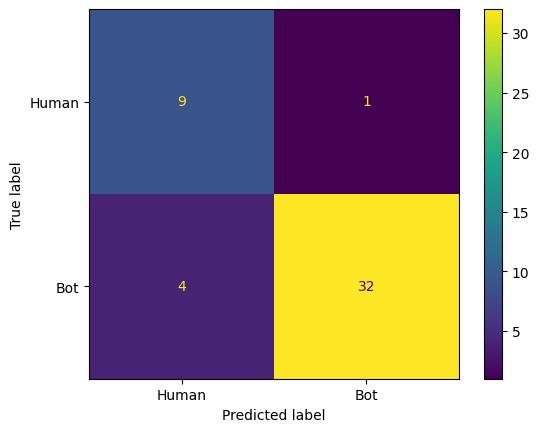

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(cm, display_labels=["Human", "Bot"])
disp.plot()
plt.show()


In [ ]:
pd.DataFrame({
    "true_label": y_test.values,
    "bot_probability": y_prob_xgb
}).head(10)


,true_label,bot_probability
0,0,0.056089
1,1,0.993825
2,0,0.104237
3,1,0.940755
4,1,0.982678
5,1,0.994023
6,1,0.991547
7,1,0.981336
8,1,0.990145
9,1,0.949158


In [ ]:
def classify_session(features, model):
    prob = model.predict_proba(features)[:, 1][0]

    if prob >= 0.90:
        return "BOT – BLOCK", prob
    elif prob >= 0.70:
        return "SUSPICIOUS – MFA / CAPTCHA", prob
    else:
        return "HUMAN", prob


In [ ]:
import pandas as pd

bot_example = pd.DataFrame([{
    "total_logins": 15,
    "session_duration_sec": 120,
    "avg_time_diff_sec": 2,
    "min_time_diff_sec": 1,
    "unique_emails": 15,
    "email_count": 15,
    "ip_count": 1,
    "logins_per_min": 7.5
}])

result, prob = classify_session(bot_example, xgb_model)
print(result, prob)


BOT – BLOCK 0.97976905


In [ ]:
human_example = pd.DataFrame([{
    "total_logins": 1,
    "session_duration_sec": 0,
    "avg_time_diff_sec": 0,
    "min_time_diff_sec": 0,
    "unique_emails": 1,
    "email_count": 1,
    "ip_count": 1,
    "logins_per_min": 0.05
}])

result, prob = classify_session(human_example, xgb_model)
print(result, prob)


HUMAN 0.07546489


In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import joblib

joblib.dump(
    xgb_model,
    "/content/drive/MyDrive/bot_detector_xgb.pkl"
)

print("Model saved")


Model saved
